In [6]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
covidData = pd.read_csv("germanyCases.csv")
covidData.head()

,Unnamed: 0,dates,confirmed,recovered,deaths,reinfection,vaccines_adm
0,1,2020-01-22,0,0,0,0,0
1,2,2020-01-23,0,0,0,0,0
2,3,2020-01-24,0,0,0,0,0
3,4,2020-01-25,0,0,0,0,0
4,5,2020-01-26,0,0,0,0,0


In [51]:
# Population of the country with data
germanyPop = 83214427
# Tuning parameter for 'steepness' of optimistic projection
alpha = 0.01471
t0 = 300
length = np.shape(covidData)[0]
# arctan fake projection of testing 
projected = np.floor(
    12000000 * ((
        np.arctan(
        alpha * (range(740) - t0 * np.ones(740))
        ) 
        + np.pi / 2
        )) / (np.pi)
)
covidData['project'] = projected
covidData.head()

,Unnamed: 0,dates,confirmed,recovered,deaths,reinfection,vaccines_adm,project
0,1,2020-01-22,0,0,0,0,0,851185.0
1,2,2020-01-23,0,0,0,0,0,853938.0
2,3,2020-01-24,0,0,0,0,0,856709.0
3,4,2020-01-25,0,0,0,0,0,859497.0
4,5,2020-01-26,0,0,0,0,0,862303.0


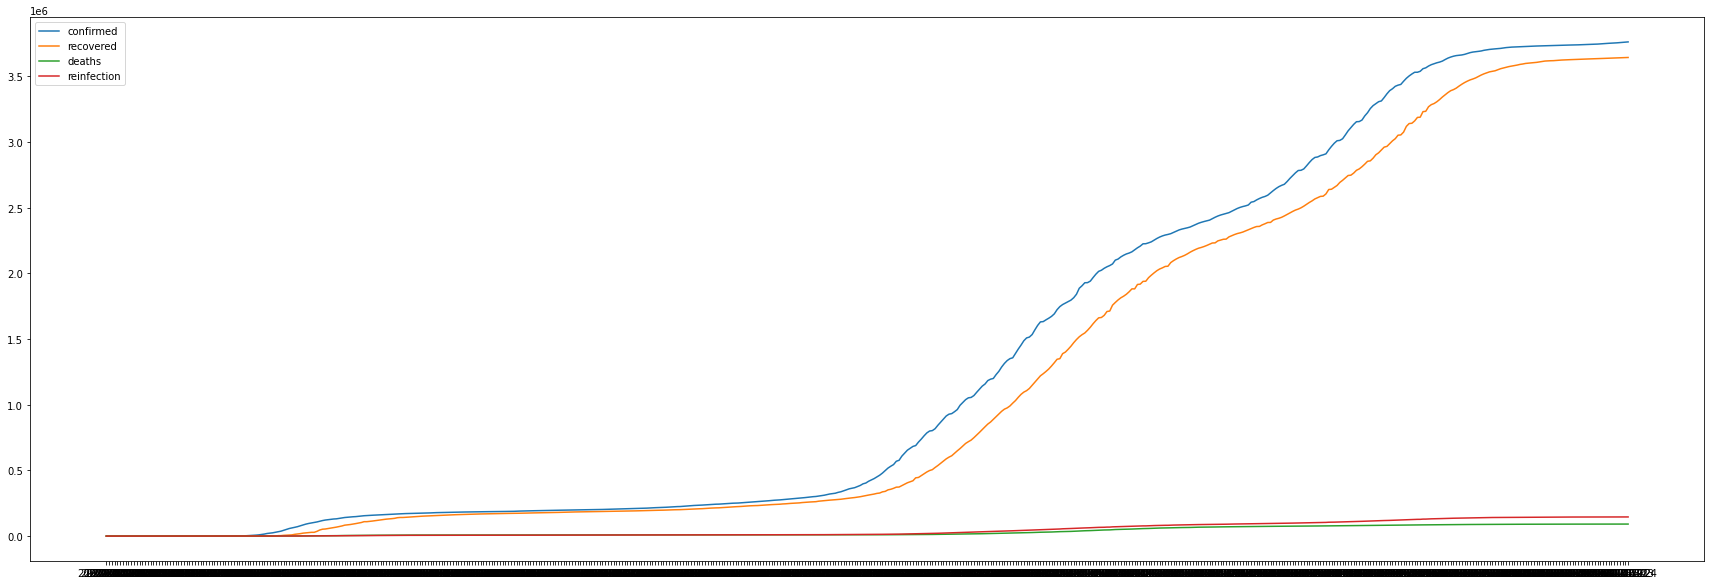

In [67]:
plt.figure(figsize = (30, 10))
cov = covidData.head(550)
plt.plot('dates', 'confirmed', data=cov)
plt.plot('dates', 'recovered', data=cov)
plt.plot('dates', 'deaths', data=cov)
plt.plot('dates', 'reinfection', data=cov)
plt.legend()

In [92]:
# Function for finding model parameters
def tuningParams(i, r, d, re, P):
    # Using definitions from the paper
    rho = 0.9
    e = 100000000000000000
    betaStar = 0
    gammaStar = 0
    nuStar = 0
    omegaStar = 0
    alphaStar = 0
    muStar = 0
    omega = np.arange(11) / 10
    alpha = np.arange(1, 101)
    for o in omega:
        for a in alpha:
            S = ((o / a) * P) - i - r - d - re
            delta = np.empty((1, 0))
            phi = np.empty((0, 4))
            for t in np.arange(100, 550):
                delta = np.append(delta,
                        np.array([i[t + 1] - i[t],
                                  r[t + 1] - r[t],
                                  d[t + 1] - d[t],
                                  re[t+1] - re[t]]))
                phi = np.append(phi, 
                       np.array([[(S[t] * i[t])/(S[t] + i[t]), -1 * i[t], -1 * i[t], r[t]],
                                 [0, i[t], 0, -1 * r[t]], 
                                 [0, 0, (1 / a) * i[t], 0], 
                                 [0, 0, 0, r[t]]]), axis=0)
            #Moore penrose inverse
            invPhi = np.linalg.pinv(phi)
            params = np.matmul(invPhi, delta)
            error = delta - np.matmul(phi, params)
            errorNorm = np.linalg.norm(error)
            #print(f'error = {errorNorm}, e  = {e}')
            if errorNorm < e:
                e = errorNorm
                betaStar = params[0]
                gammaStar = params[1]
                nuStar = params[2]
                muStar = params[3]
                omegaStar = o
                alphaStar = a
            #print(delta, phi)
    paramEstimates = np.array([betaStar, gammaStar, nuStar, muStar])
    print(paramEstimates)

tuningParams(covidData['confirmed'], covidData['recovered'], covidData['deaths'], covidData['reinfection'], germanyPop)


[0.04666899 0.00408793 0.08738379 0.0003605 ]
0.7724561208902916
